In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/ben_afflek/
  inflating: data/ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg  
  inflating: data/ben_afflek/httpafilesbiographycomimageuploadcfillcssrgbdprgfacehqwMTENDgMDUODczNDcNTcjpg.jpg  
  inflating: data/ben_afflek/httpbpblogspotcomedLMjVpRGkSWexgsXjkNIAAAAAAAADWgFFtAUqBlhAsjpg.jpg  
  inflating: data/ben_afflek/httpcsvkmeuaafdfjpg.jpg  
  inflating: data/ben_afflek/httpcsvkmeuadecafjpg.jpg  
  inflating: data/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data

In [ ]:

import os
data_dir=os.getcwd()+'/data'
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.image import imsave as imsave
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from tensorflow import keras
import numpy as np
import random

import tensorflow as tf

In [ ]:
batch_size=32
IMG_HEIGHT=128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_HEIGHT),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_HEIGHT),
  batch_size=batch_size)

Found 118 files belonging to 5 classes.
Using 95 files for training.
Found 118 files belonging to 5 classes.
Using 23 files for validation.


['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']
(32, 128, 128, 3)


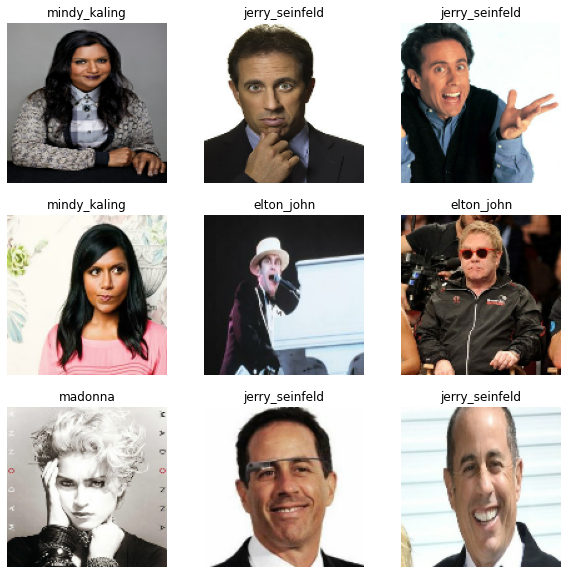

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT,IMG_HEIGHT,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 4, 4, 1280)


In [ ]:
base_model.trainable = False


In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT,IMG_HEIGHT,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile( optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(val_ds)

1/1 [==============================] - 0s 2ms/step - loss: 2.8375 - accuracy: 0.1304


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.84
initial accuracy: 0.13


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
3/3 [==============================] - 0s 145ms/step - loss: 2.3793 - accuracy: 0.2316 - val_loss: 1.8941 - val_accuracy: 0.2174
Epoch 2/100
3/3 [==============================] - 0s 42ms/step - loss: 2.0149 - accuracy: 0.2000 - val_loss: 1.5698 - val_accuracy: 0.3478
Epoch 3/100
3/3 [==============================] - 0s 43ms/step - loss: 1.8360 - accuracy: 0.3053 - val_loss: 1.4687 - val_accuracy: 0.3913
Epoch 4/100
3/3 [==============================] - 0s 40ms/step - loss: 1.5661 - accuracy: 0.3789 - val_loss: 1.4356 - val_accuracy: 0.3913
Epoch 5/100
3/3 [==============================] - 0s 42ms/step - loss: 1.2180 - accuracy: 0.5789 - val_loss: 1.3994 - val_accuracy: 0.3913
Epoch 6/100
3/3 [==============================] - 0s 44ms/step - loss: 1.4110 - accuracy: 0.4421 - val_loss: 1.3167 - val_accuracy: 0.4348
Epoch 7/100
3/3 [==============================] - 0s 41ms/step - loss: 1.0916 - accuracy: 0.5579 - val_loss: 1.1823 - val_accuracy: 0.5217
Epoch 8/100
3/3 [==

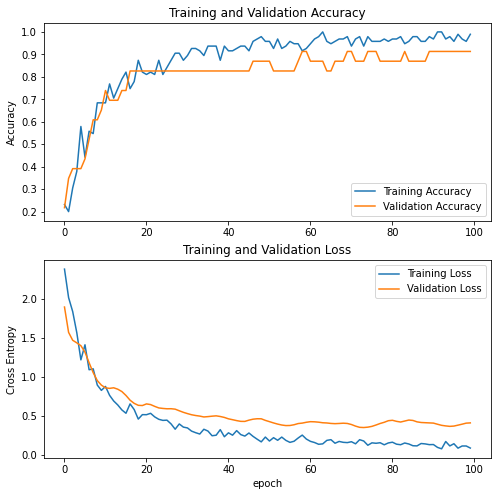

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [ ]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 8ms/step - loss: 0.4112 - accuracy: 0.9130
Test accuracy : 0.9130434989929199


In [ ]:
model.save("my_model.h5")
model=tf.keras.models.load_model('my_model.h5')


This image most likely belongs to mindy_kaling with a 89.76 percent confidence.
This image most likely belongs to madonna with a 99.70 percent confidence.
This image most likely belongs to mindy_kaling with a 72.18 percent confidence.
This image most likely belongs to mindy_kaling with a 46.13 percent confidence.
This image most likely belongs to mindy_kaling with a 64.49 percent confidence.
This image most likely belongs to mindy_kaling with a 91.06 percent confidence.
This image most likely belongs to jerry_seinfeld with a 98.92 percent confidence.
This image most likely belongs to elton_john with a 88.75 percent confidence.
This image most likely belongs to mindy_kaling with a 53.91 percent confidence.


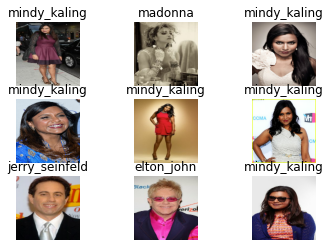

In [ ]:
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        img_array = keras.preprocessing.image.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)
        #plt.imshow(img)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )        

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")